In [74]:
import scispacy
import spacy
import joblib
import re
import string
import re
from nltk import word_tokenize
from collections import Counter
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from scipy.sparse import coo_matrix, hstack

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertTokenizer, BertModel
import gensim.downloader as api
from gensim.models import KeyedVectors

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from sentence_transformers import SentenceTransformer

In [75]:
df=pd.read_csv("dfnew.csv")

In [76]:
additional_keywords = ["attacks","medications","comfortable","thorax","temperature","compressions","ablation","pressure","blood","chest", "stroke", "heart","cpr", "breathing", "breath","heart","breathe","blood","head","difficulty","pressure","shortness","left","muscle","drugs","arm","hurting"]

In [77]:
def keywords_extract(text):
    d=''
    for keyword in additional_keywords:
        matches = re.findall(r'\b{}\b'.format(re.escape(keyword)), text, re.IGNORECASE)
        if matches:
            d+= ", ".join(matches)
            d=d+' '
    d=d+'-'
    return (d)
df["additional_keywords"] = df.clean_text.map(keywords_extract)

In [78]:
df

,audio,text,target,clean_text,key_words_chemical,key_words_disease,additional_keywords
0,2021-01-01/4/CH4_03004448_51.txt,0002.0s 0002.5s SPEAKER_01: Umm\n 0003.3s 000...,Chest Pain,umm need dont care tanya okay number 740971896...,-,pain pain -,"heart breath heart breathe, breathe, breathe h..."
1,2021-01-13/6/CH6_05004302_51.txt,"0011.3s 0013.5s SPEAKER_00: 911, what's the a...",Sick Person,911 whats address emergency 317 chelsea street...,-,fever headaches -,"comfortable temperature, temperature, temperat..."
2,2021-03-01/6/CH6_05004634_51.txt,"0010.0s 0012.7s SPEAKER_00: 911, what is the ...",DOMESTIC,911 address emergency 79 rock creek drive 79 r...,alcohol -,bleeding -,drugs arm -
3,2021-03-01/6/CH6_05004634_51.txt,"0010.0s 0012.7s SPEAKER_00: 911, what is the ...",INJURED PERSON - BASIC,911 address emergency 79 rock creek drive 79 r...,alcohol -,bleeding -,drugs arm -
4,2021-04-10/5/CH5_0400486D_51.txt,"0011.0s 0012.9s SPEAKER_01: 911, what's the a...",DIFFICULTY BREATHING,911 whats address emergency hello 91 need ambu...,oxygen oxygen -,death -,"comfortable blood, blood, blood heart, heart b..."
...,...,...,...,...,...,...,...
1456,2021-06-29/2/CH2_010051FC_146.txt,"0012.7s 0014.9s SPEAKER_01: 911, what's the a...",911 CELLULAR HANG-UP/OPEN/MISDIAL,911 whats address emergency mother earth turn ...,-,-,-
1457,2021-06-29/5/CH5_04004F82_146.txt,0003.5s 0005.8s SPEAKER_01: Oh my god there's...,LOCKOUT - VEHICLE/OTHER,oh god theres sheriff right 911 two deaths eme...,oxygen oxygen oxygen -,deaths -,-
1458,2021-06-30/5/CH5_04004F99_146.txt,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",SUSPICIOUS PERSON,911 whats address emergency really emergency g...,-,-,-
1459,2021-06-30/5/CH5_04004F99_146.txt,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",INJURED PERSON - BASIC,911 whats address emergency really emergency g...,-,-,-


In [79]:
unique_categories_num = df['target'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_categories_num.index, 'Count': unique_categories_num.values})
counts_df_full

,Category,Count
0,SICK PERSON,147
1,INJURED FROM A FALL,117
2,DIFFICULTY BREATHING,71
3,LIFT ASSIST,54
4,Sick Person,53
...,...,...
157,SHOOTING,1
158,TRASH DUMPING,1
159,THEFT IN PROGRESS,1
160,Suspicious Mail,1


In [80]:
df['target'] = df['target'].str.lower()
df['New Category'] = df['target'].apply(lambda x: 'Fire' if 'fire' in x.lower() else ('cardiac_arrest' if 'cardiac' in x.lower() else ('heart_attack' if 'heart' in x.lower() else x)))
df['New Category'] = df['New Category'].apply(lambda x: 'heart_attack' if 'chest pain' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'stroke' if 'stroke' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'Major_trauma' if 'injured' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'Major_trauma' if 'injury' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'seizure' if 'convulsion/seizures' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'difficulty breathing' if 'overdose / poisoning' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'difficulty breathing' if 'overdose - poisoning' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'difficulty breathing' if 'choking' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'Major_trauma' if 'fall' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'difficulty breathing' if 'overdose/poisoning' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: '911 cellular hang-up/open/misdial' if '911 hang-up/open/misdial' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: '911 cellular hang-up/open/misdial' if 'duplicate call' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'suspicious person' if 'suspicious person/vehicle' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'heart_attack' if 'cardiac_arrest' in x.lower() else x)

In [81]:
unique_categories_num = df['New Category'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_categories_num.index, 'Count': unique_categories_num.values})
counts_df_full

,Category,Count
0,Major_trauma,205
1,sick person,200
2,difficulty breathing,131
3,lift assist,88
4,heart_attack,86
...,...,...
80,lacerations - bleeding,1
81,medical alarm,1
82,meet in person,1
83,exposer,1


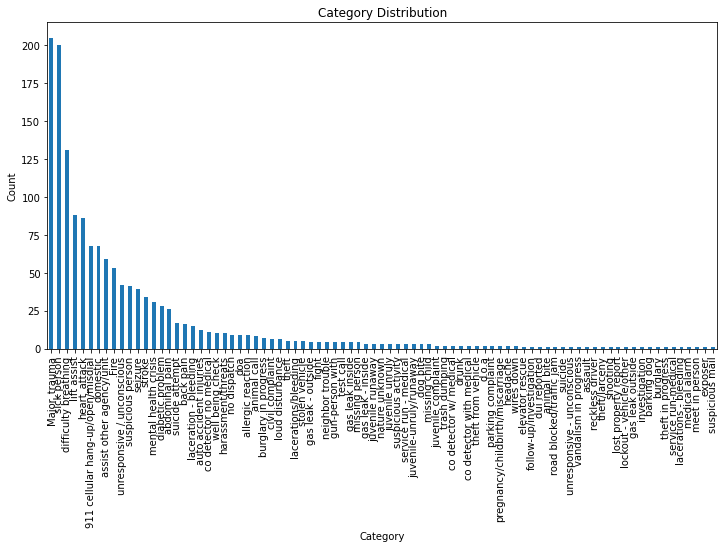

In [82]:
fig = plt.figure(figsize=(12, 6))
unique_categories_num.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [83]:
category_counts = df['New Category'].value_counts()
limit = 59
selected_categories = category_counts[category_counts > limit].index.tolist()
df = df.loc[df['New Category'].isin(selected_categories)]

In [84]:
unique_category_nums = df['New Category'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_category_nums.index, 'Count': unique_category_nums.values})
counts_df_full

,Category,Count
0,Major_trauma,205
1,sick person,200
2,difficulty breathing,131
3,lift assist,88
4,heart_attack,86
5,domestic,68
6,911 cellular hang-up/open/misdial,68


In [85]:
df['New Category'] = df['New Category'].apply(lambda x: 'heart_attack' if 'stroke' in x.lower() else x)
df['New Category'] = df['New Category'].apply(lambda x: 'others' if x != 'heart_attack' else x)

/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
unique_category_nums = df['New Category'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_category_nums.index, 'Count': unique_category_nums.values})
counts_df_full

,Category,Count
0,others,760
1,heart_attack,86


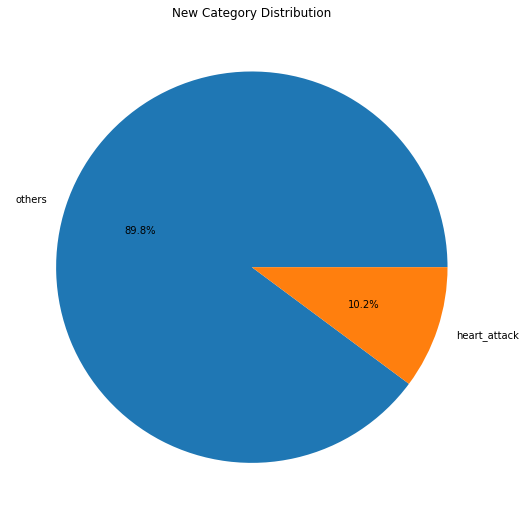

In [87]:
fig = plt.figure(figsize=(9, 9))
plt.pie(unique_category_nums.values, labels= unique_category_nums.index, autopct='%1.1f%%')
plt.title('New Category Distribution')
plt.show()

In [88]:
df1 = pd.DataFrame(
    dict(
        ntext = df['text'],
        text=df["clean_text"],
        target= df["New Category"],
        key_words_chemical= df["key_words_chemical"],
        key_words_disease	= df["key_words_disease"],
    additional_keywords = df["additional_keywords"]))

In [89]:
df1

,ntext,text,target,key_words_chemical,key_words_disease,additional_keywords
0,0002.0s 0002.5s SPEAKER_01: Umm\n 0003.3s 000...,umm need dont care tanya okay number 740971896...,heart_attack,-,pain pain -,"heart breath heart breathe, breathe, breathe h..."
1,"0011.3s 0013.5s SPEAKER_00: 911, what's the a...",911 whats address emergency 317 chelsea street...,others,-,fever headaches -,"comfortable temperature, temperature, temperat..."
2,"0010.0s 0012.7s SPEAKER_00: 911, what is the ...",911 address emergency 79 rock creek drive 79 r...,others,alcohol -,bleeding -,drugs arm -
3,"0010.0s 0012.7s SPEAKER_00: 911, what is the ...",911 address emergency 79 rock creek drive 79 r...,others,alcohol -,bleeding -,drugs arm -
4,"0011.0s 0012.9s SPEAKER_01: 911, what's the a...",911 whats address emergency hello 91 need ambu...,others,oxygen oxygen -,death -,"comfortable blood, blood, blood heart, heart b..."
...,...,...,...,...,...,...
1451,0004.5s 0005.5s SPEAKER_04: She needs to grow...,needs grow 911 whats address emergency address...,others,-,-,-
1454,0002.2s 0005.0s SPEAKER_00: yeah\n 0009.9s 00...,yeah thank 911 address emergency reported ofte...,others,-,-,-
1456,"0012.7s 0014.9s SPEAKER_01: 911, what's the a...",911 whats address emergency mother earth turn ...,others,-,-,-
1459,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",911 whats address emergency really emergency g...,others,-,-,-


In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
embeddings_st = model.encode(df1['text'].tolist())

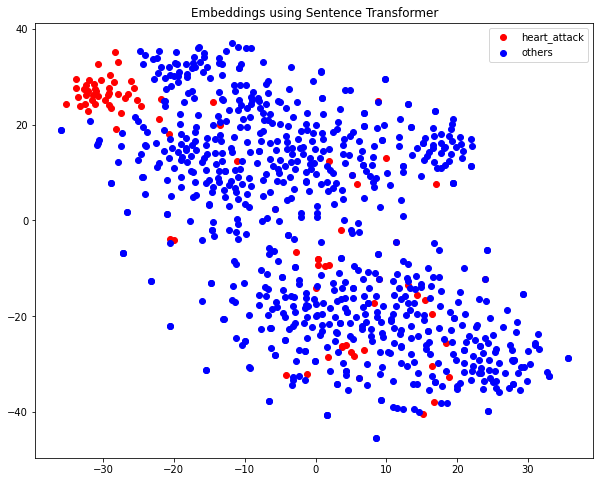

In [20]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2dst = tsne.fit_transform(embeddings_st)

# Plotting
targets = df1['target'].unique()
colors = ['r' if target == 'heart_attack' else 'b' for target in df1['target']]

plt.figure(figsize=(10, 8))
for i, target in enumerate(targets):
    indices = df1['target'] == target
    plt.scatter(embeddings_2dst[indices, 0], embeddings_2dst[indices, 1], label=target, c=colors[i])
plt.title("Embeddings using Sentence Transformer")
plt.legend()
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_st, df1['target'], test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='rbf') # You can experiment with different kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for sentence transformers:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9352941176470588
Classification Report for sentence transformers:
              precision    recall  f1-score   support

heart_attack       1.00      0.42      0.59        19
      others       0.93      1.00      0.96       151

    accuracy                           0.94       170
   macro avg       0.97      0.71      0.78       170
weighted avg       0.94      0.94      0.92       170



In [23]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [24]:
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df1['text'])]

In [25]:
model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [26]:
embeddings_d2v = [model.infer_vector(doc.words) for doc in tagged_data]

In [27]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2dd2v = tsne.fit_transform(embeddings_d2v)

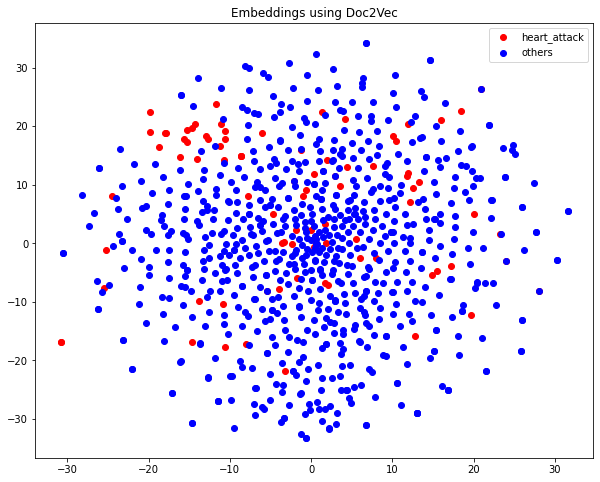

In [28]:
colors = ['r' if target == 'heart_attack' else 'b' for target in df1['target']]

plt.figure(figsize=(10, 8))
for i, target in enumerate(df1['target'].unique()):
    indices = df1['target'] == target
    plt.scatter(embeddings_2dd2v[indices, 0], embeddings_2dd2v[indices, 1], label=target, c=colors[i])
plt.title("Embeddings using Doc2Vec")
plt.legend()
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_d2v, df1['target'], test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='rbf') # You can experiment with different kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report doc2vec:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9235294117647059
Classification Report doc2vec:
              precision    recall  f1-score   support

heart_attack       1.00      0.32      0.48        19
      others       0.92      1.00      0.96       151

    accuracy                           0.92       170
   macro avg       0.96      0.66      0.72       170
weighted avg       0.93      0.92      0.91       170



In [43]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
def get_text_model3(texts, model, tokenizer):
    vectors = []
    max_length = model.config.max_position_embeddings  # Maximum token limit
    
    for text in texts:
        # Tokenize and truncate the text if needed
        inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        vectors.append(embeddings)
    
    return np.array(vectors)

In [51]:
e1 = get_text_model3(df1.text, model, tokenizer)

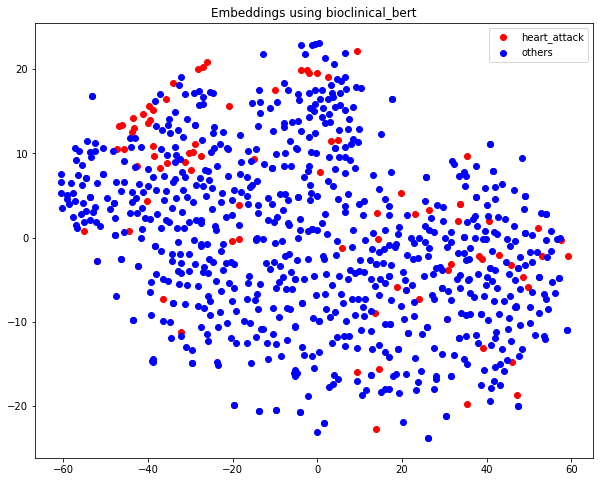

In [55]:
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(e1)
colors = ['r' if target == 'heart_attack' else 'b' for target in df1['target']]

plt.figure(figsize=(10, 8))
for i, target in enumerate(df1['target'].unique()):
    indices = df1['target'] == target
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=target, c=colors[i])
plt.title("Embeddings using bioclinical_bert")
plt.legend()
plt.show()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(e1, df1['target'], test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='rbf') # You can experiment with different kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report doc2vec:")
print(classification_report(y_test, y_pred))

Accuracy: 0.888235294117647
Classification Report doc2vec:
              precision    recall  f1-score   support

heart_attack       0.00      0.00      0.00        19
      others       0.89      1.00      0.94       151

    accuracy                           0.89       170
   macro avg       0.44      0.50      0.47       170
weighted avg       0.79      0.89      0.84       170



/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [58]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
def get_text_bert_uncased(texts, model, tokenizer):
    vectors = []
    max_length = model.config.max_position_embeddings  # Maximum token limit
    
    for text in texts:
        # Tokenize and truncate the text if needed
        inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        vectors.append(embeddings)
    
    return np.array(vectors)

In [61]:
e1 = get_text_bert_uncased(df1.text, model, tokenizer)

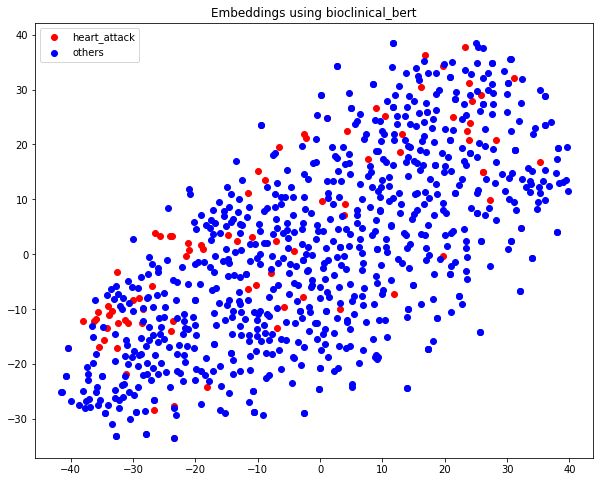

In [62]:
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(e1)
colors = ['r' if target == 'heart_attack' else 'b' for target in df1['target']]

plt.figure(figsize=(10, 8))
for i, target in enumerate(df1['target'].unique()):
    indices = df1['target'] == target
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=target, c=colors[i])
plt.title("Embeddings using bert_uncased")
plt.legend()
plt.show()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(e1, df1['target'], test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='rbf') # You can experiment with different kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report bert_uncased:")
print(classification_report(y_test, y_pred))

Accuracy: 0.888235294117647
Classification Report bert_uncased:
              precision    recall  f1-score   support

heart_attack       0.00      0.00      0.00        19
      others       0.89      1.00      0.94       151

    accuracy                           0.89       170
   macro avg       0.44      0.50      0.47       170
weighted avg       0.79      0.89      0.84       170



/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [64]:
model_name = "monologg/biobert_v1.1_pubmed"
tokenizer1 = AutoTokenizer.from_pretrained(model_name)
model1 = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at monologg/biobert_v1.1_pubmed were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
def get_text_biobert(texts, model, tokenizer):
    vectors = []
    max_length = model.config.max_position_embeddings  # Maximum token limit
    
    for text in texts:
        # Tokenize and truncate the text if needed
        inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        vectors.append(embeddings)
    
    return np.array(vectors)

In [66]:
e_biobert = get_text_biobert(df1.text, model, tokenizer)

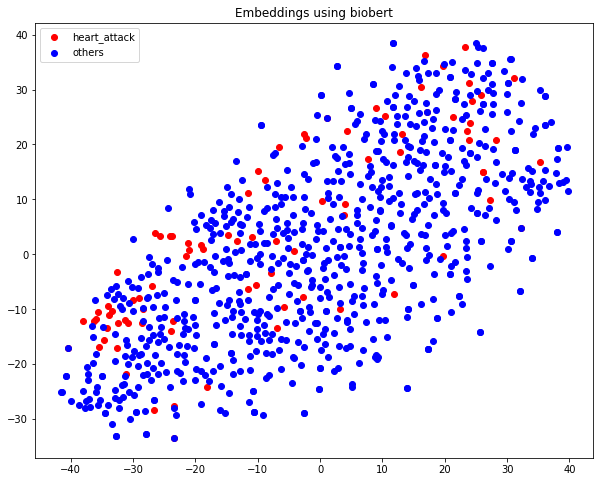

In [67]:
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(e_biobert)
colors = ['r' if target == 'heart_attack' else 'b' for target in df1['target']]

plt.figure(figsize=(10, 8))
for i, target in enumerate(df1['target'].unique()):
    indices = df1['target'] == target
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=target, c=colors[i])
plt.title("Embeddings using biobert")
plt.legend()
plt.show()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(e_biobert, df1['target'], test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='rbf') # You can experiment with different kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report biobert:")
print(classification_report(y_test, y_pred))

Accuracy: 0.888235294117647
Classification Report biobert:
              precision    recall  f1-score   support

heart_attack       0.00      0.00      0.00        19
      others       0.89      1.00      0.94       151

    accuracy                           0.89       170
   macro avg       0.44      0.50      0.47       170
weighted avg       0.79      0.89      0.84       170



/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [90]:
model = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')

In [91]:
embeddings_stmed = model.encode(df1['text'].tolist())

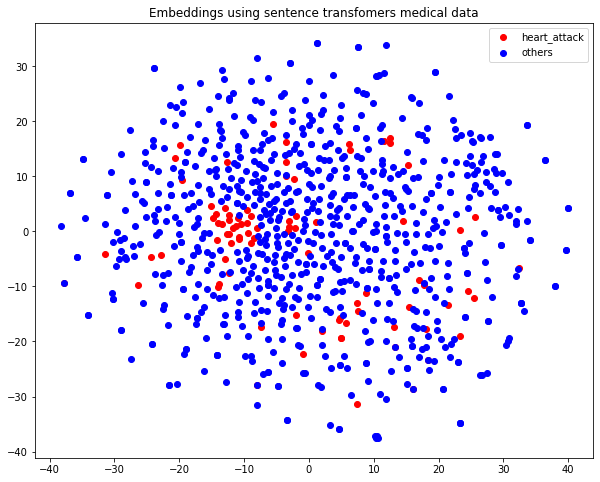

In [92]:
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(embeddings_stmed)
colors = ['r' if target == 'heart_attack' else 'b' for target in df1['target']]

plt.figure(figsize=(10, 8))
for i, target in enumerate(df1['target'].unique()):
    indices = df1['target'] == target
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=target, c=colors[i])
plt.title("Embeddings using sentence transfomers medical data")
plt.legend()
plt.show()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_stmed, df1['target'], test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='rbf') # You can experiment with different kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report biobert:")
print(classification_report(y_test, y_pred))

Accuracy: 0.888235294117647
Classification Report biobert:
              precision    recall  f1-score   support

heart_attack       0.00      0.00      0.00        19
      others       0.89      1.00      0.94       151

    accuracy                           0.89       170
   macro avg       0.44      0.50      0.47       170
weighted avg       0.79      0.89      0.84       170



/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/PAS0536/harshinikavuru26/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta